In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

model = hub.load('https://bit.ly/metrabs_l')  # Takes about 3 minutes
! wget -q https://istvansarandi.com/eccv22_demo/test.jpg


In [ ]:
img = tf.image.decode_image(tf.io.read_file('test.jpg'))
img = tf.image.decode_image(tf.io.read_file('/content/offset_939720.jpg'))
pred = model.detect_poses(img, skeleton='smpl+head_30')
pred['poses3d'].shape

NotFoundError: ignored

In [ ]:
def plot_results(image, pred, joint_names, joint_edges):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.patches import Rectangle
    fig = plt.figure(figsize=(10, 5.2))
    image_ax = fig.add_subplot(1, 2, 1)
    image_ax.imshow(image.numpy())
    for x, y, w, h, c in pred['boxes'].numpy():
        image_ax.add_patch(Rectangle((x, y), w, h, fill=False))

    pose_ax = fig.add_subplot(1, 2, 2, projection='3d')
    pose_ax.view_init(5, -75)
    pose_ax.set_xlim3d(-1500, 500)
    pose_ax.set_zlim3d(-1500, 500)
    pose_ax.set_ylim3d(2000, 5000)
    poses3d = pred['poses3d'].numpy()
    poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]
    for pose3d, pose2d in zip(poses3d, pred['poses2d'].numpy()):
        for i_start, i_end in joint_edges:
            image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)
            pose_ax.plot(*zip(pose3d[i_start], pose3d[i_end]), marker='o', markersize=2)
        image_ax.scatter(*pose2d.T, s=2)
        pose_ax.scatter(*pose3d.T, s=2)

In [ ]:
joint_names = model.per_skeleton_joint_names['smpl+head_30'].numpy().astype(str)
joint_edges = model.per_skeleton_joint_edges['smpl+head_30'].numpy()
#plot_results(img, pred, joint_names, joint_edges)

In [ ]:
import os
from zipfile import ZipFile
from IPython.display import Image
import numpy as np
import csv

!unzip -q rowing_poses.zip

unzip:  cannot find or open rowing_poses.zip, rowing_poses.zip.zip or rowing_poses.zip.ZIP.


In [ ]:

dataset_in = 'rowing_poses'

new_list_keypoints = ["part_stroke"]
for i in range(len(joint_names)):
    new_list_keypoints.append(joint_names[i]+"_x")
    new_list_keypoints.append(joint_names[i]+"_y")
    new_list_keypoints.append(joint_names[i]+"_z")

# Replace 'output_file.csv' with the desired output CSV file name
output_file = 'output_file.csv'

# Write the list as the header row in the CSV file
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(new_list_keypoints)

print(f"Header row written to {output_file}")


parent_directory = '/content/rowing_poses'

for subdir in os.listdir(parent_directory):
    subdir_path = os.path.join(parent_directory, subdir)
    if os.path.isdir(subdir_path):
        print(f"Processing images in folder: {subdir}")

        # Iterate through image files in each subdirectory
        for file in os.listdir(subdir_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_path = os.path.join(subdir_path, file)

                img = tf.image.decode_image(tf.io.read_file(image_path))
                pred = model.detect_poses(img, skeleton='smpl+head_30')
                #print(pred['poses3d'].numpy()[0])
                if pred['poses3d'].numpy().size != 0:
                  coords = pred['poses3d'].numpy()[0]
                  coordinates_1d = coords.ravel()
                  if "catch" in str(subdir):
                    coordinates_1d = np.insert(coords.ravel(), 0, 1)
                  elif "drive" in str(subdir):
                    coordinates_1d = np.insert(coords.ravel(), 0, 2)
                  if "finish" in str(subdir):
                    coordinates_1d = np.insert(coords.ravel(), 0, 3)
                  # output_file = 'output_file.csv'
                  with open(output_file, mode='a', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow(coordinates_1d)

# You can filter the files based on file extensions if necessary
#image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
#image_files = [f for f in files if any(f.endswith(ext) for ext in image_extensions)]


Header row written to output_file.csv
Processing images in folder: .ipynb_checkpoints
Processing images in folder: finish
Processing images in folder: mid drive
Processing images in folder: catch


In [ ]:
import random
import pandas as pd
input_file = 'output_file.csv'
output_file = 'shuffled.csv'


sv_data = []
with open(input_file, mode='r', newline='') as file:
    reader = csv.reader(file)
    csv_data = list(reader)

# Extract the header (first row)
header = csv_data[0]

# Shuffle the rows (excluding the first row)
shuffled_data = random.sample(csv_data[1:], len(csv_data) - 1)

# Insert the header at the beginning
shuffled_data.insert(0, header)

# Write the shuffled data back to a new CSV file
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(shuffled_data)

print(f"Rows shuffled and saved to {output_file}")

FileNotFoundError: ignored

In [ ]:
data = pd.read_csv('shuffled.csv')

In [ ]:
from sklearn.model_selection import train_test_split

# Specify the ratio for the test set (e.g., 20%)
test_size = 0.2

# Split the data into training and test sets
train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)


In [ ]:
# Save the training dataset to a CSV file
train_data.to_csv('train_data.csv', index=False)

# Save the test dataset to a CSV file
test_data.to_csv('test_data.csv', index=False)

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import pandas as pd
# Replace 'train_data.csv' with the path to your training CSV file
data = pd.read_csv('train_data.csv')
features = data.iloc[:, 1:].values
labels = data.iloc[:, 0].values
features_tensor = torch.from_numpy(features).float()
labels_tensor = torch.from_numpy(labels).long()

data_test = pd.read_csv('test_data.csv')
features_test = data_test.iloc[:, 1:].values
labels_test = data_test.iloc[:, 0].values
features_tensor_test = torch.from_numpy(features_test).float()
labels_tensor_test = torch.from_numpy(labels_test).long()

print(labels_tensor)
print(len(labels_tensor))
print(features_tensor)
print(len(features_tensor))

print(labels_tensor_test)
print(len(labels_tensor_test))
print(features_tensor_test)
print(len(features_tensor_test))

tensor([2, 3, 2,  ..., 2, 1, 1])
1475
tensor([[ 337.2856,  228.5036, 1422.8162,  ...,  293.5655, -413.2748,
         1218.6760],
        [  17.3932,  269.0455, 1861.6123,  ...,  -14.3467, -478.2838,
         1745.6680],
        [-197.2304,  268.7943, 1348.1666,  ..., -191.8648, -494.8490,
         1244.8445],
        ...,
        [-164.3601,  178.7300, 1417.1936,  ..., -142.7348, -452.8836,
         1239.1345],
        [-145.4922,  301.2944, 1743.7019,  ...,   67.7341, -308.0495,
         1801.5110],
        [ -35.2915,   -4.2309, 1731.9574,  ...,  -39.5331, -488.9044,
         1294.4080]])
1475
tensor([1, 2, 3, 2, 2, 1, 1, 1, 1, 1, 1, 3, 2, 2, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3,
        1, 1, 3, 1, 2, 3, 2, 1, 2, 2, 3, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1,
        2, 2, 2, 3, 2, 1, 2, 2, 3, 2, 1, 1, 1, 3, 2, 2, 3, 1, 2, 1, 1, 3, 3, 1,
        3, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 1, 3, 2, 2, 3, 3, 2, 3, 3, 3,
        2, 3, 2, 3, 1, 1, 2, 1, 3, 2, 3, 3, 3, 3, 2, 2, 1, 2, 1, 2, 3, 2, 3, 

In [2]:
import torch
import torch.nn as nn

class DeepNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [3]:
learning_rate = 0.001
num_epochs = 35
batch_size = 36

In [4]:
model = DeepNN(90, 128, 128, 4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [5]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(features_tensor, labels_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Epoch [1/35], Loss: 18.5864
Epoch [2/35], Loss: 1.2394
Epoch [3/35], Loss: 2.5756
Epoch [4/35], Loss: 1.0708
Epoch [5/35], Loss: 2.3065
Epoch [6/35], Loss: 1.7879
Epoch [7/35], Loss: 1.1333
Epoch [8/35], Loss: 0.6722
Epoch [9/35], Loss: 0.8528
Epoch [10/35], Loss: 1.0792
Epoch [11/35], Loss: 0.9577
Epoch [12/35], Loss: 0.8604
Epoch [13/35], Loss: 0.5090
Epoch [14/35], Loss: 0.5586
Epoch [15/35], Loss: 0.7152
Epoch [16/35], Loss: 0.7698
Epoch [17/35], Loss: 0.3943
Epoch [18/35], Loss: 0.4376
Epoch [19/35], Loss: 0.4963
Epoch [20/35], Loss: 0.3462
Epoch [21/35], Loss: 0.4060
Epoch [22/35], Loss: 0.3154
Epoch [23/35], Loss: 0.1878
Epoch [24/35], Loss: 0.3489
Epoch [25/35], Loss: 0.3722
Epoch [26/35], Loss: 0.3607
Epoch [27/35], Loss: 0.2907
Epoch [28/35], Loss: 0.2575
Epoch [29/35], Loss: 0.3949
Epoch [30/35], Loss: 0.4726
Epoch [31/35], Loss: 0.2945
Epoch [32/35], Loss: 0.2393
Epoch [33/35], Loss: 0.2161
Epoch [34/35], Loss: 0.2793
Epoch [35/35], Loss: 0.2093


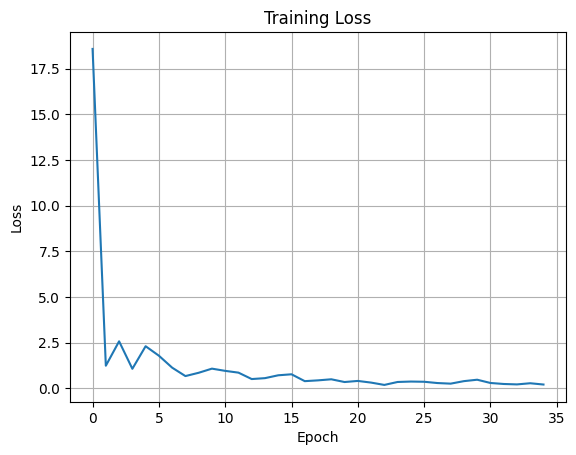

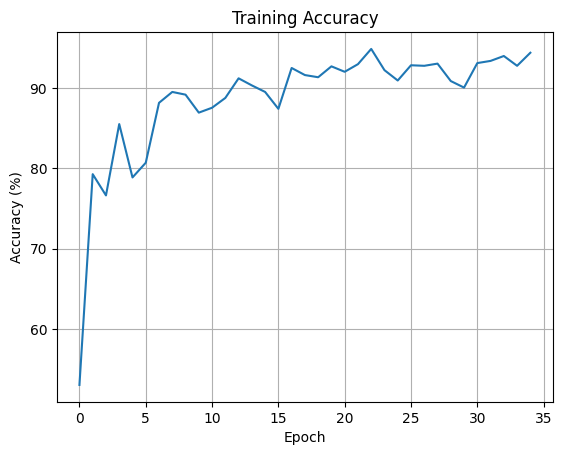

94.37288135593221


In [6]:
losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:  # Assuming you have a train_loader
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    train_accuracies.append(accuracy)

    # Calculate the average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Visualize the training loss
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()
print(train_accuracies[-1])

In [7]:
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0
features_tensor_test = torch.tensor(features_test, dtype=torch.float32)
labels_tensor_test = torch.tensor(labels_test, dtype=torch.long)
dataset_test = TensorDataset(features_tensor_test, labels_tensor_test)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

# Iterate through the test data
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test data: {accuracy:.2f}%')

Accuracy on the test data: 91.60%


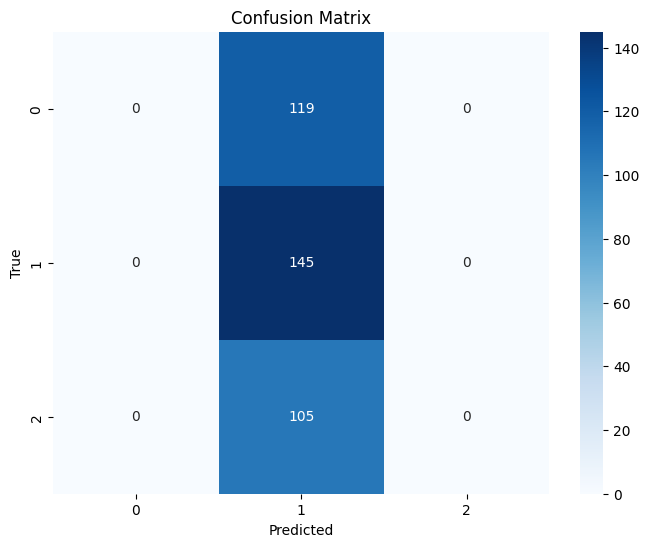

In [9]:
model.eval()
predicted_labels = []
true_labels = []
from sklearn.metrics import confusion_matrix
import seaborn as sns

with torch.no_grad():
    for inputs, labels in test_loader:  # Assuming you have a test_loader
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(3), yticklabels=range(3))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=5aa4e17f20b52f62108e82ba375806ba3939190a48fb616776dbf4025ccb1f58
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
from torchviz import make_dot

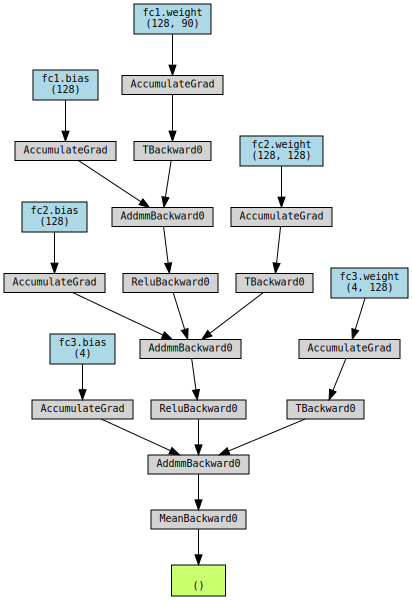

In [ ]:
model = DeepNN(90, 128, 128, 4)
y = model(features_tensor_test)
make_dot(y.mean(), params=dict(model.named_parameters()))


In [ ]:
# new_list_keypoints = ["part_stroke"]
# for i in range(len(joint_names)):
#     new_list_keypoints.append(joint_names[i]+"_x")
#     new_list_keypoints.append(joint_names[i]+"_y")
#     new_list_keypoints.append(joint_names[i]+"_z")

# print(new_list_keypoints)

# # Replace 'output_file.csv' with the desired output CSV file name
# output_file = 'output_file.csv'

# # Write the list as the header row in the CSV file
# with open(output_file, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(new_list_keypoints)

# print(f"Header row written to {output_file}")

# # Now, you can iterate through the image files and perform actions on each image
# for image_file in image_files[:20]:
#     image_path = os.path.join(folder_path, image_file)

#     # You can, for example, display each image using IPython if you have that library installed
#     #from IPython.display import Image
#     #display(Image(filename=image_path))

#     # Or you can perform any other operations on the images
#     # For example, you can process the images using a library like PIL (Pillow)
#     # from PIL import Image as PILImage
#     # image = PILImage.open(image_path)
#     # Do something with the image here
#     img = tf.image.decode_image(tf.io.read_file(image_path))
#     pred = model.detect_poses(img, skeleton='smpl+head_30')
#     #print(pred['poses3d'].numpy()[0])
#     coords = pred['poses3d'].numpy()[0]
#     coordinates_1d = coords.ravel()
#     coordinates_1d = np.insert(coords.ravel(), 0, 1)
#     # output_file = 'output_file.csv'
#     with open(output_file, mode='a', newline='') as file:
#       writer = csv.writer(file)
#       writer.writerow(coordinates_1d)
#     ###########workinggggggg plot imahes##########
#     #plot_results(img, pred, joint_names, joint_edges)

#     print(f"Processing: {image_file}")





['part_stroke', 'pelv_smpl_x', 'pelv_smpl_y', 'pelv_smpl_z', 'lhip_smpl_x', 'lhip_smpl_y', 'lhip_smpl_z', 'rhip_smpl_x', 'rhip_smpl_y', 'rhip_smpl_z', 'bell_smpl_x', 'bell_smpl_y', 'bell_smpl_z', 'lkne_smpl_x', 'lkne_smpl_y', 'lkne_smpl_z', 'rkne_smpl_x', 'rkne_smpl_y', 'rkne_smpl_z', 'spin_smpl_x', 'spin_smpl_y', 'spin_smpl_z', 'lank_smpl_x', 'lank_smpl_y', 'lank_smpl_z', 'rank_smpl_x', 'rank_smpl_y', 'rank_smpl_z', 'thor_smpl_x', 'thor_smpl_y', 'thor_smpl_z', 'ltoe_smpl_x', 'ltoe_smpl_y', 'ltoe_smpl_z', 'rtoe_smpl_x', 'rtoe_smpl_y', 'rtoe_smpl_z', 'neck_smpl_x', 'neck_smpl_y', 'neck_smpl_z', 'lcla_smpl_x', 'lcla_smpl_y', 'lcla_smpl_z', 'rcla_smpl_x', 'rcla_smpl_y', 'rcla_smpl_z', 'head_smpl_x', 'head_smpl_y', 'head_smpl_z', 'lsho_smpl_x', 'lsho_smpl_y', 'lsho_smpl_z', 'rsho_smpl_x', 'rsho_smpl_y', 'rsho_smpl_z', 'lelb_smpl_x', 'lelb_smpl_y', 'lelb_smpl_z', 'relb_smpl_x', 'relb_smpl_y', 'relb_smpl_z', 'lwri_smpl_x', 'lwri_smpl_y', 'lwri_smpl_z', 'rwri_smpl_x', 'rwri_smpl_y', 'rwri_smp